# Invert Radon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from scipy.fftpack import fft, ifft, fftfreq
from scipy.interpolate import interp1d
from scipy.ndimage import rotate
from scipy import misc

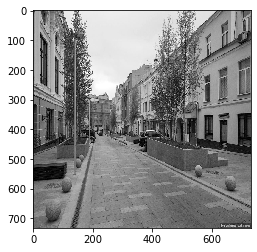

In [3]:
gray = cv2.imread('./Data/00s.png', 0)
plt.imshow(gray, cmap='gray')

In [4]:
def discrete_radon_transform(img, steps):
    sinogram = np.zeros((len(img), steps), dtype='float64')
    for s in range(steps):
        rotation = rotate(img, -s*180/steps, reshape=False).astype('float64')
        sinogram[:,s] = sum(rotation)
    
    sinogram = cv2.resize(sinogram, dsize=(img.shape), interpolation=cv2.INTER_CUBIC)
    return sinogram

In [5]:
theta    = np.linspace(0., 180., max(gray.shape), endpoint=False)
sinogram = discrete_radon_transform(gray, 180)

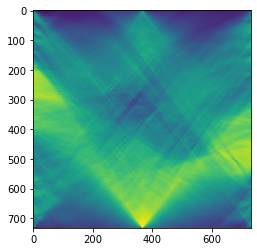

In [6]:
plt.imshow(sinogram)

In [18]:
def sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    #np.pad pads an array, 
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)

In [22]:
def iradon_transform(sinogram, theta=None, interpolation='linear'):
    output_size = sinogram.shape[0]
    sinogram = sinogram_circle_to_square(sinogram)
    th = (np.pi / 180.0)*theta
    
    # np.ceil округляет в верх
    projection_size = max(64, int(2**np.ceil(np.log2(2*sinogram.shape[0]))))
    size_width = ((0, projection_size - sinogram.shape[0]),(0,0))
    image = np.pad(sinogram, size_width, mode='constant', constant_values=0)
    
    #digital freq
    f = fftfreq(projection_size).reshape(-1,1)
    #angular freq
    omega = 2 * np.pi * f                      
    
    # Ram filter
    fourier_filter = 2 * np.abs(f) 
    projection = fft(image, axis=0)*fourier_filter
    
    # real только настоящие часть от комплексного числа
    radon_filtered = np.real(ifft(projection, axis=0))
    radon_filtered = radon_filtered[:sinogram.shape[0],:]
    reconstructed = np.zeros((output_size, output_size))
    
    #Обратное проектирование 
    mid_index = sinogram.shape[0] // 2
    [X, Y] = np.mgrid[0:output_size, 0:output_size]
    xpr = X - int(output_size) // 2
    ypr = Y - int(output_size) // 2
    
    #Интерполяция 
    ip_types = ('linear','nearest', 'cubic')
    if interpolation not in ip_types:
        raise ValueError("wrong interpolaion type")

    for i in range(len(theta)):
        t = ypr * np.cos(th[i]) - xpr * np.sin(th[i])
        x = np.arange(radon_filtered.shape[0])-mid_index
        if interpolation == 'linear':
            backprojected = np.interp(t, x, radon_filtered[:, i], left=0, right=0)
        else:
            interpolant = interp1d(x, radon_filtered[:, i], kind=interpolation, bounds_error=False, fill_value=0)
            backprojected = interpolant(t)
        reconstructed += backprojected

    radius = output_size // 2
    cirrcle = (xpr ** 2 + ypr ** 2) >= radius ** 2
    reconstructed[cirrcle] = 0.  

    return reconstructed * np.pi / (2*180)

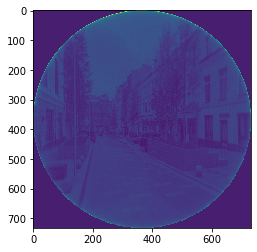

In [23]:
plt.imshow(iradon_transform(sinogram, theta=theta))